# Clustering dataset

# Sources
1. TSNE Explanation: https://distill.pub/2016/misread-tsne/
1. HDBSCAN Explanation: https://towardsdatascience.com/understanding-hdbscan-and-density-based-clustering-121dbee1320e
1. HDBSCAN original article: https://link.springer.com/chapter/10.1007%2F978-3-642-37456-2_14
1. HDBSCAN: https://honeynet.github.io/cuckooml/2016/07/19/clustering-evaluation/
1. Advantage using UMAP prior to clustering: https://link.springer.com/chapter/10.1007/978-3-030-51935-3_34

@article{mcinnes2017hdbscan,
  title={hdbscan: Hierarchical density based clustering},
  author={McInnes, Leland and Healy, John and Astels, Steve},
  journal={The Journal of Open Source Software},
  volume={2},
  number={11},
  pages={205},
  year={2017}
}

@misc{Ulyanov2016,
  author = {Ulyanov, Dmitry},
  title = {Multicore-TSNE},
  year = {2016},
  publisher = {GitHub},
  journal = {GitHub repository},
  howpublished = {\url{https://github.com/DmitryUlyanov/Multicore-TSNE}},
}

Detecting topics in the tweets during COVID-19 crisis by the diputados.

It is used the cleaned dataset from the hypertext repository

# Imports

In [85]:
# General import
import os
import json
import re
import requests
from pathlib import Path
import time
from itertools import chain
from collections import Counter

In [86]:
# NLP 
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

In [87]:
# Data imports
import numpy as np 
from numpy import save, load
import pickle

import pandas as pd 
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import seaborn as sns

from sklearn import preprocessing
import config_cluster

In [88]:
#! pip install hdbscan
#!pip install umap-learn
#!pip install umap-learn[plot]
import hdbscan
import MulticoreTSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.plot as umap_plot
import umap.umap_ as umap
from wordcloud import WordCloud

In [89]:
# Notebooks imports
#from IPython.display import clear_output  # to avoid cluttering when using with tqdm. just put clear_output() at the end of the inside loop
from tqdm.auto import tqdm
from tqdm import tqdm

In [90]:
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100

# Functions

# Load data

In [7]:
without_rt = True
root_filename = config_cluster.root_name
num_cpu = config_cluster.num_cpu
#list_clustering_method = config_cluster.list_clustering_method
# list_type_txt = ["raw", "clean"]
list_type_txt = config_cluster.list_type_txt
list_datasets = config_cluster.list_datasets
list_n_dim = config_cluster.list_n_dim
# list_n_dim = ["original"]
# list_cluster_size = range(10, 20)
list_cluster_size = config_cluster.list_cluster_size
list_min_size = config_cluster.list_min_size

In [8]:
# Filenames to load
tweets_filename = './{}/data/{}_added_features.ftr'.format(root_filename, root_filename)
df = pd.read_feather(tweets_filename)
#df = df.sample(frac=sample_threshold, random_state=random_state)
try:
    del df['level_0']
except KeyError:
    pass
df.shape

(584544, 23)

In [9]:
# Size with party 5 only
df[df['party_5'].notnull()].shape

(486024, 23)

In [10]:
df[(df['word_count'] >=5) & df['party_5'].notnull()].shape

(454175, 23)

In [11]:
df[(df['lang_label'] == 'es') & (df['lang_proba'] >= 0.6) & (df['word_count'] >=5) & (df['party_5'].notnull())].shape

(385265, 23)

In [12]:
df[(df['rt_status'] == False) & (df['lang_label'] == 'es') & (df['lang_proba'] >= 0.6) & (df['party_5'].notnull()) & (df['word_count'] >=5)].shape


(104253, 23)

In [13]:
df['include'] = (df['rt_status'] == False) & (df['lang_label'] == 'es') & (df['lang_proba'] >= 0.6) & (df['party_5'].notnull()) & (df['word_count'] >=5)

In [14]:
df['include'].value_counts()

False    480291
True     104253
Name: include, dtype: int64

In [15]:
# Clean hashtags
covid_list = ['covid19', 'coronavirus', 'covid_19', 'covid2019','covid-19', 'covidー19']
df['hashtags_clean'] = df['hashtags'].apply(lambda x: ['covid19' if i.lower() in covid_list else i.lower() for i in x])
df['hashtags_clean']
df.shape

(584544, 23)

In [16]:
#Load report for clustering
for type_txt in list_type_txt:
    grid_resuls_filename = "./{}/outputs/grid_search_hdbscan_{}_{}.csv".format(root_filename, type_txt, list_datasets[0])

    df_hdbscan = pd.read_csv(grid_resuls_filename).sort_values(by='validity_index_score', ascending=False)
    df_hdbscan['prop_top_1'] =  df_hdbscan['top_1'] / (df_hdbscan['total'] - df_hdbscan['noise'])
    df_hdbscan['prop_noise'] =  df_hdbscan['noise'] / df_hdbscan['total']
    df_hdbscan['prop_top_10'] =  df_hdbscan['top_10'] / (df_hdbscan['total'] - df_hdbscan['noise'])
    df_hdbscan = df_hdbscan.reset_index(drop=True)
df_hdbscan.shape

(3828, 12)

In [17]:
df_hdbscan.head(50)

,n_dim,min_sample,min_cluster_size,validity_index_score,noise,top_10,top_1,n_clusters,total,prop_top_1,prop_noise,prop_top_10
0,2,8,275,0.558178,22730,50728,24174,57,104253,0.296530,0.218027,0.622254
1,2,8,250,0.546863,21611,50728,24174,63,104253,0.292515,0.207294,0.613828
2,2,9,175,0.524765,23843,45285,23518,81,104253,0.292476,0.228703,0.563176
3,2,9,200,0.521678,21720,49051,23518,73,104253,0.284953,0.208339,0.594320
4,2,14,425,0.509817,21304,57544,31003,42,104253,0.373760,0.204349,0.693727
5,2,9,150,0.498499,23237,45285,23518,90,104253,0.290288,0.222890,0.558964
6,2,40,125,0.482962,21744,49358,26744,89,104253,0.324134,0.208570,0.598214
7,2,14,450,0.482430,21738,57544,31003,40,104253,0.375726,0.208512,0.697376
8,2,35,90,0.477113,22244,48604,26053,102,104253,0.317685,0.213366,0.592667
9,2,14,475,0.473853,23099,57544,31003,37,104253,0.382027,0.221567,0.709072


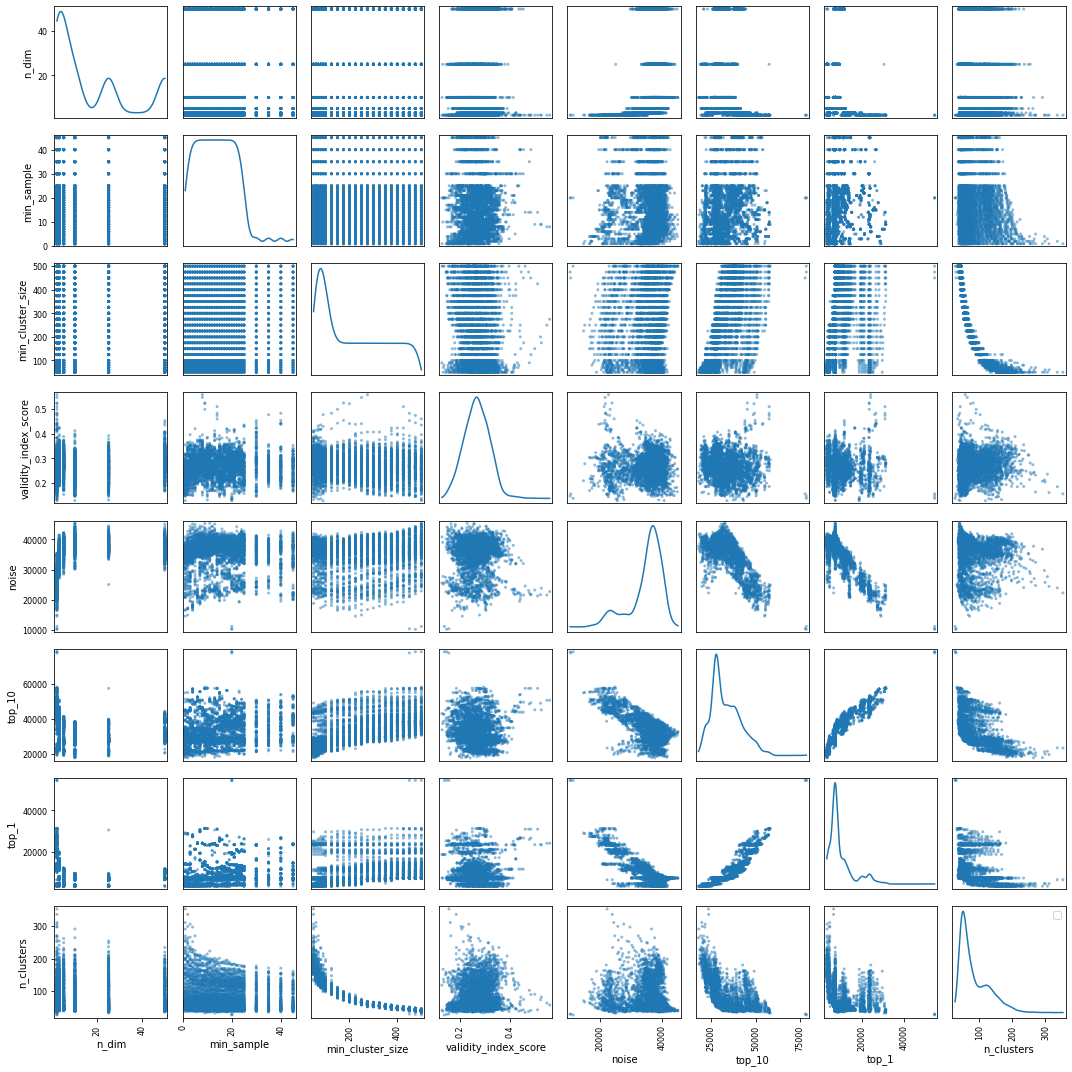

In [18]:
from pandas import plotting
cols_to_chek = [x for x in df_hdbscan.columns if x in ['n_clusters', 'size_first_cluster', 'min_cluster_size', 'min_sample', 'n_dim', 'noise', 'top_1', 'top_10', 'validity_index_score']]

#fig, ax = plt.subplots(figsize=(15, 8)) 
plotting.scatter_matrix(df_hdbscan[cols_to_chek], alpha=0.5, diagonal='kde', figsize=(15, 15))
#fig.suptitle('Descriptive stats for hyper parameters selection', fontsize=16)

#plt.xticks(rotation=90)
plt.tight_layout()
plt.legend('')
plt.savefig('./{}/plots/hyper_params_selection_hdbscan.png'.format(root_filename),  dpi=300, 
            format='png', 
            bbox_inches='tight')
#corr = df_hdbscan.corr().as_matrix()

## Select the best cluster

In [19]:
best_type_txt = type_txt
best_dataset = list_datasets[0] 

best_min_cluster_size = df_hdbscan.sort_values(by='validity_index_score', ascending=False).head(1)['min_cluster_size'].values[0]
best_min_sample = df_hdbscan.sort_values(by='validity_index_score', ascending=False).head(1)['min_sample'].values[0]
best_n_dim = df_hdbscan.sort_values(by='validity_index_score', ascending=False).head(1)['n_dim'].values[0]
#clusterer = load("./{}/clusters/hdbscan_{}_{}_cluster-size_{}_min-samples_{}_n-dim_{}.pkl".format(root_filename, best_type_txt, best_dataset, best_min_cluster_size, best_min_sample, best_n_dim), allow_pickle=True)

In [20]:
best_min_sample

8

In [21]:
sent_emb_filename = "./{}/sentences_emb/sent_embeddings_{}_{}.npy".format(root_filename, type_txt, list_datasets[0])
sent_emb = load(sent_emb_filename)
#len(sent_emb.tolist())
#df['sent_emb_{}'.format(type_txt)] = sent_emb.tolist()
umap_filename = "./{}/dim_reduction/umap_{}_{}_{}.pkl".format(root_filename, best_n_dim, type_txt, list_datasets[0])
umap = load(umap_filename, allow_pickle=True)
sent_emb = umap.transform(sent_emb)
print('{}: {}'.format(type_txt, len(sent_emb)))

Wed Nov  4 12:35:35 2020 Building and compiling search function
txt_wo_entities: 104253


In [22]:
# Check if the length of the included tweets are equal to the size of the sent_emb
assert df['include'].sum() == len(sent_emb)

In [23]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=int(best_min_cluster_size),
                            min_samples=int(best_min_sample),
                            gen_min_span_tree=True,
                            allow_single_cluster=True)
clusterer.fit(sent_emb)

HDBSCAN(allow_single_cluster=True, gen_min_span_tree=True, min_cluster_size=275,
        min_samples=8)

In [24]:
# Check validity of index but not working right now
#hdbscan.validity.validity_index(X=clusterer._raw_data.astype('double'), labels=clusterer.labels_)

In [25]:
# The df and the list of labels have different size but the order is corresponding to the value True in the column 'include'
# Create a new list with the same length than the original df to create a new list
labels_resized = list()
idx = 0
for val_mask in df['include']:
    if val_mask == True:
        labels_resized.append(int(str(clusterer.labels_[idx])))
        idx+=1
    else:
        labels_resized.append(np.NaN)
        
df['label_hdbscan'] = labels_resized

In [26]:
# Update include to only have tweets not labelled as noise
df['include'] = ((df['include'] == True) & (df['label_hdbscan'] != -1))

## Record the new df with the labels

In [27]:
df.reset_index().to_feather('./{}/data/{}_added_features.ftr'.format(root_filename, root_filename))  

# Plotting and analysing quality of the cluster

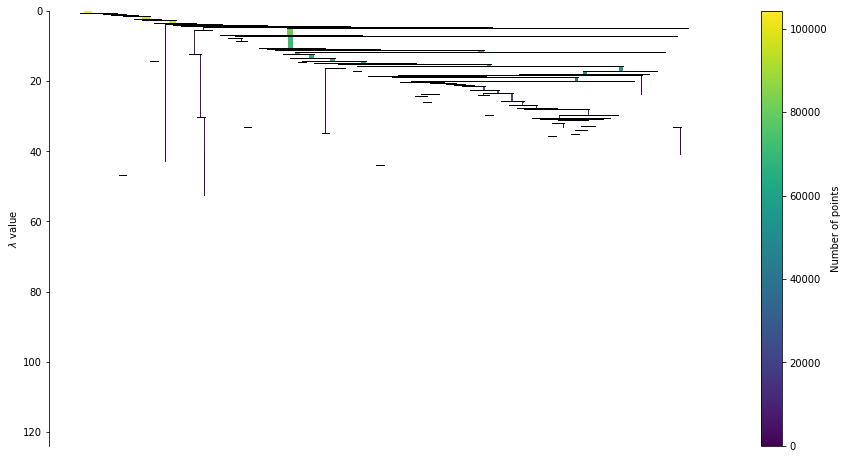

In [28]:
fig, ax = plt.subplots(figsize=(15, 8)) 

clusterer.condensed_tree_.plot(#select_clusters=True,
                               #selection_palette=sns.color_palette('deep', 8)
)
plt.savefig('./{}/plots/hdbscan_tree.png'.format(root_filename),  dpi=300, 
            format='png', 
            bbox_inches='tight')

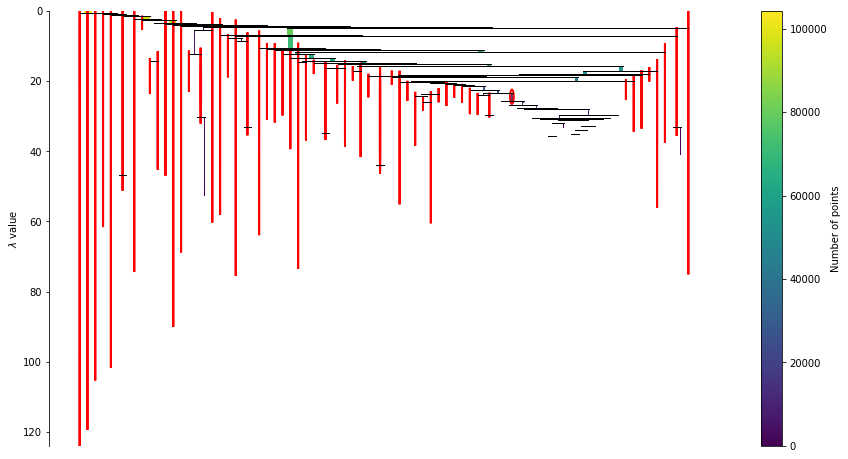

In [29]:
fig, ax = plt.subplots(figsize=(15, 8)) 

clusterer.condensed_tree_.plot(select_clusters=True,
                               #selection_palette=sns.color_palette('deep', 8)
)
plt.savefig('./{}/plots/hdbscan_tree_selected.png'.format(root_filename),  dpi=300, 
            format='png', 
            bbox_inches='tight')

In [30]:
total_labels = df.groupby('label_hdbscan').size().to_frame()
total_labels.columns = ['count']


total_labels  = total_labels.reset_index()
total_labels.columns = ['labels', 'count']
total_labels.to_csv('./{}/outputs/freq_labels.csv'.format(root_filename), index=False)

total_labels.sort_values(by='count', ascending=False)

,labels,count
55,54.0,24174
0,-1.0,22730
17,16.0,6789
41,40.0,4707
20,19.0,3487
57,56.0,2568
33,32.0,2194
18,17.0,1852
14,13.0,1767
45,44.0,1628


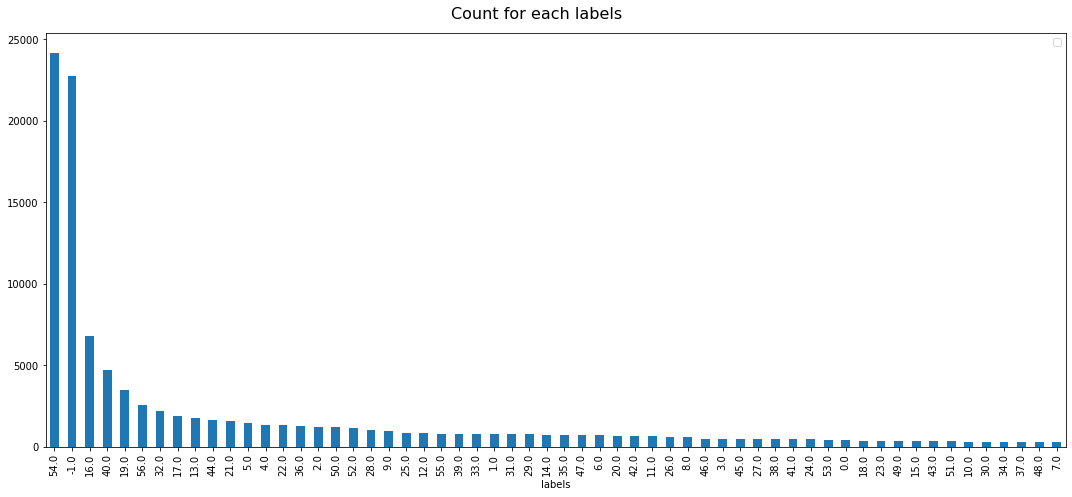

In [31]:
fig, ax = plt.subplots(figsize=(15,7)) 
total_labels.sort_values(by='count',ascending=False).plot(kind='bar', y='count',x='labels', ax=ax)
fig.suptitle('Count for each labels', fontsize=16)
#plt.xticks(rotation=90)
plt.tight_layout()
plt.legend('')
plt.savefig('./{}/plots/count_labels_cluster.png'.format(root_filename),  dpi=300, 
            format='png', 
            bbox_inches='tight')

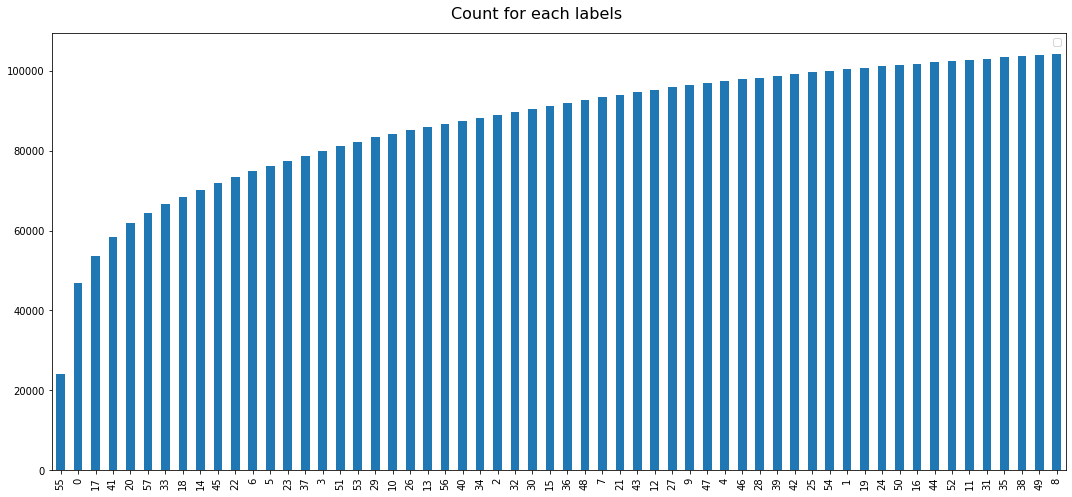

In [32]:
fig, ax = plt.subplots(figsize=(15,7)) 
total_labels.sort_values(by='count',ascending=False).cumsum().plot(kind='bar',y='count', ax=ax)
fig.suptitle('Count for each labels', fontsize=16)
#plt.xticks(rotation=90)
plt.tight_layout()
plt.legend('')
plt.savefig('./{}/plots/cumulative_labels_cluster.png'.format(root_filename),  dpi=300, 
            format='png', 
            bbox_inches='tight')

# Mapping the cluster on a 2-d space using umap

In [33]:
if best_n_dim != 2:
    umap_2d_full_filename = './{}/dim_reduction/umap_2_{}_{}.pkl'.format(root_filename, best_type_txt, best_dataset)
    umap_2d = pickle.load(open(umap_2d_full_filename, 'rb'))
    projection_full = umap_2d.transform(sent_emb)
else:
    projection_full = sent_emb

In [34]:
sent_emb_wo_noise = list()
for emb, labels in zip(sent_emb, df[df['label_hdbscan'].notnull()]['label_hdbscan']):
    if labels != -1.0:
        sent_emb_wo_noise.append(emb)
sent_emb_wo_noise = np.array(sent_emb_wo_noise)
sent_emb_filename_w_o_noise = "./{}/sentences_emb/sent_embeddings_{}_{}_without_noise.npy".format(root_filename,best_type_txt, best_dataset)
save(sent_emb_filename_w_o_noise, sent_emb_wo_noise)


if best_n_dim !=2:
    umap_2d_without_noise_filename = './{}/dim_reduction/umap_2_{}_{}_c-size_{}_min-samp_{}_n-dim_{}.pkl'.format(root_filename, best_type_txt, best_dataset, best_min_cluster_size, best_min_samp, best_dim)

    data = sent_emb_wo_noise
    umap_2d_without_noise = umap.UMAP(low_memory=True, n_neighbors=15, min_dist=0.0, n_components=2).fit(sent_emb_wo_noise)
    pickle.dump(umap_2d_without_noise,open(umap_2d_without_noise_filename, "wb", ), )
    projection_without_noise = umap_2d_without_noise.transform(sent_emb_wo_noise)
    
else:
    projection_without_noise = sent_emb_wo_noise

In [76]:
def exemplars(cluster_id, condensed_tree):
    raw_tree = condensed_tree._raw_tree
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree['child_size'] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree['lambda_val'][raw_tree['parent'] == leaf].max()
        points = raw_tree['child'][(raw_tree['parent'] == leaf) &
                                   (raw_tree['lambda_val'] == max_lambda)]
        result = np.hstack((result, points))
    return result.astype(np.int)
tree = clusterer.condensed_tree_
plot_kwds={'alpha':0.25, 's':60, 'linewidths':0}
palette = sns.color_palette('deep', 60)
for i, c in enumerate(tree._select_clusters()):
    c_exemplars = exemplars(c, tree)
    plt.scatter(projection_full.T[0][c_exemplars], projection_full.T[1][c_exemplars], color=palette[i])

    plt.scatter(projection_full.T[0][c_exemplars], projection_full.T[1][c_exemplars], color=palette[i])


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

No handles with labels found to put in legend.


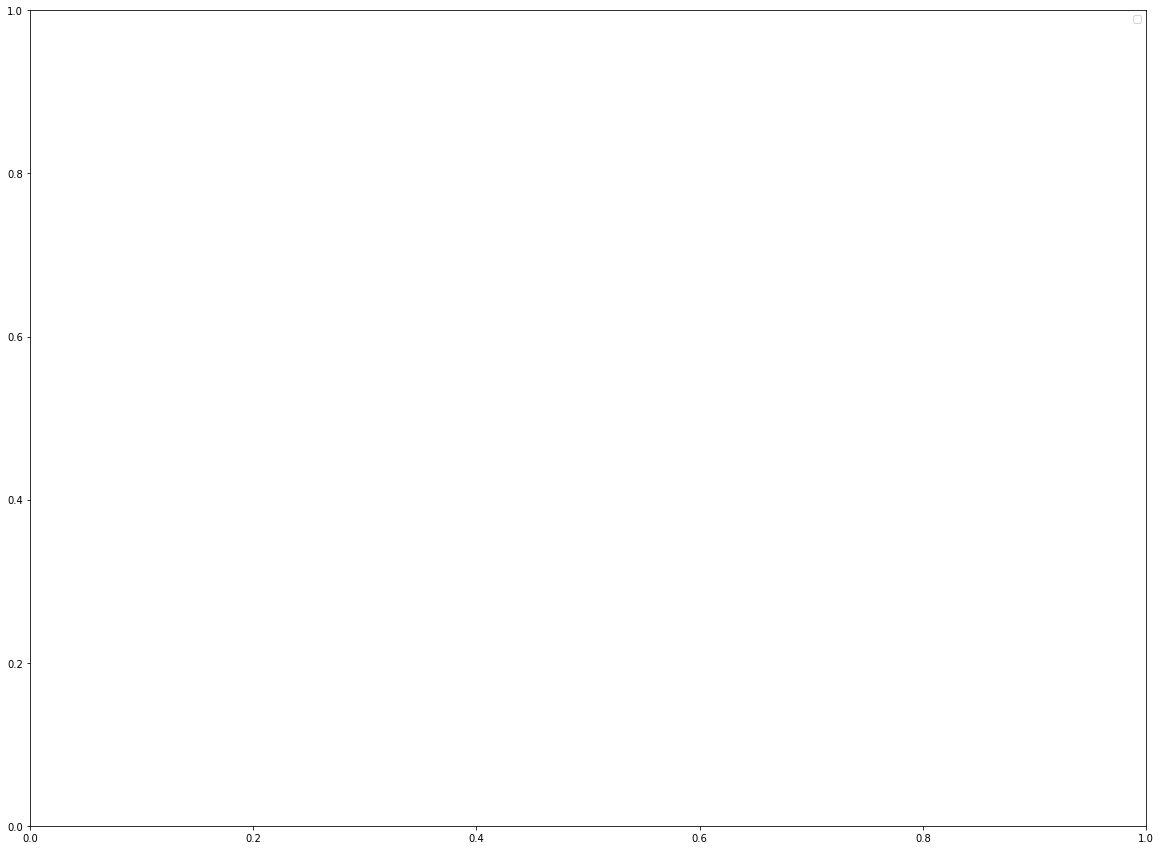

In [73]:
plt.figure(figsize=(20,15))

color_palette = sns.color_palette('Spectral', len(np.unique(clusterer.labels_)))

#cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5)  for x in clusterer.labels_]
#cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]
#plt.scatter(*projection_full.T, s=1, linewidth=0, c=cluster_member_colors, alpha=0.5)


#sns.scatterplot(x=projection_full.T[0], y=projection_full.T[1], s=1, linewidth=0,
 #               hue=clusterer.labels_, palette=color_palette, alpha=0.5) #c=cluster_member_colors, alpha=0.5)



    
    
plt.legend(ncol=2)

plt.savefig('./{}/plots/2d_vis_{}_{}_c-size_{}_min-samp_{}_n-dim_{}.png'.format(root_filename, best_type_txt, best_dataset, best_min_cluster_size, best_min_sample, best_n_dim),  dpi=300, 
            format='png',
            bbox_inches='tight')

# Sample only what to include for later analysis 

In [36]:
df = df[df['include'] == True]

IndexError: index 102724 is out of bounds for axis 0 with size 81523

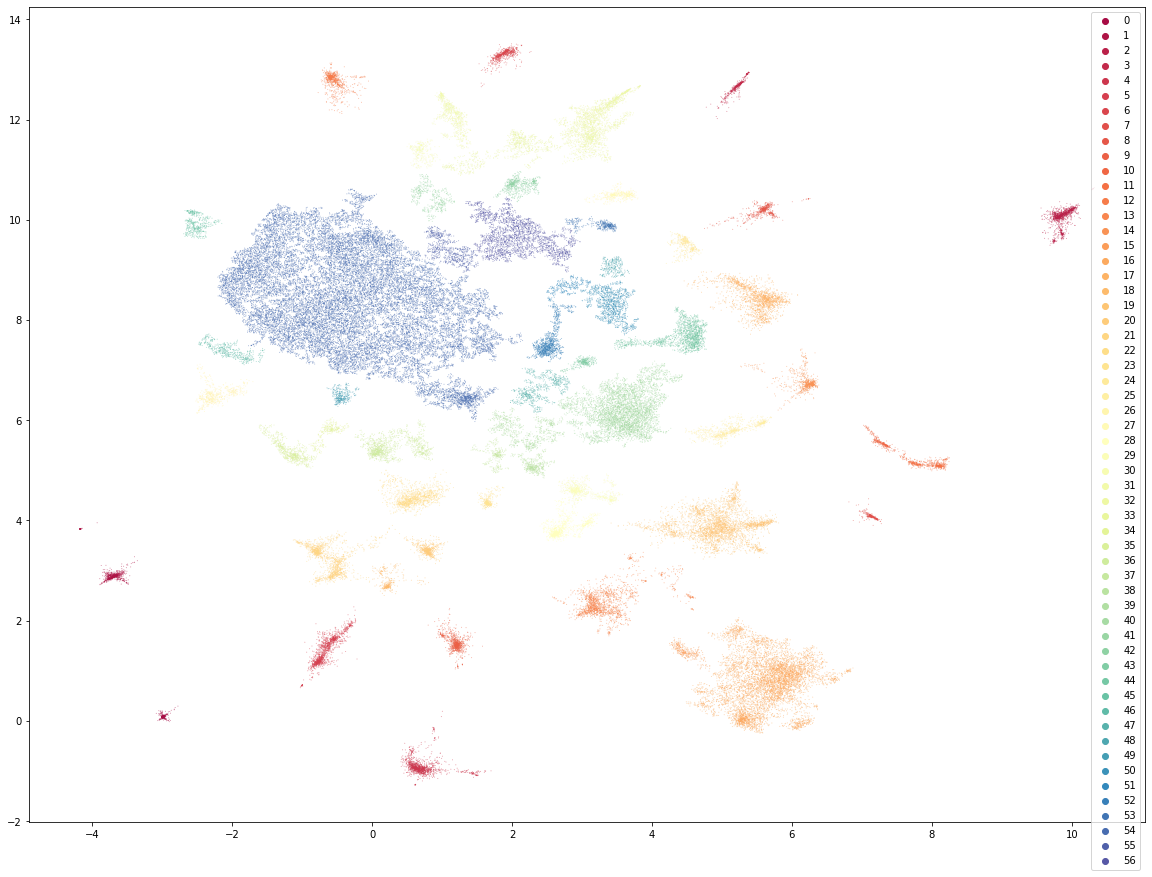

In [66]:
plt.figure(figsize=(20,15))
#color_palette = sns.color_palette("cet_cyclic_mrybm_35_75_c68", len(np.unique(clusterer.labels_)) -1)#, as_cmap=True,)
color_palette = sns.color_palette('Spectral', n_colors=len(set(clusterer.labels_))-1)



cluster_member_colors = list()
for label, proba in zip(clusterer.labels_, clusterer.probabilities_):
    if label != -1:
        color = sns.desaturate(color_palette[label], proba)
        cluster_member_colors.append(color)
        

sns.scatterplot(x=projection_without_noise.T[0],y=projection_without_noise.T[1], s=1, linewidth=0,
                hue=[x for x in clusterer.labels_ if x != -1],
               palette=color_palette, alpha=0.5) #c=cluster_member_colors, alpha=0.5)


plt.legend(ncol=2)

plt.savefig('./{}/plots/2d_vis_{}_{}_c-size_{}_min-samp_{}_n-dim_{}_wo_noise.png'.format(root_filename, best_type_txt, best_dataset, best_min_cluster_size, best_min_sample, best_n_dim),  dpi=300, 
            format='png',
            bbox_inches='tight')


# Details of the different clusters

In [77]:
selected_clusters = clusterer.condensed_tree_._select_clusters()
raw_condensed_tree = clusterer.condensed_tree_._raw_tree

exemplars = []
for cluster in selected_clusters:
    print(cluster)
    
    cluster_exemplars = np.array([], dtype=np.int64)
    for leaf in clusterer._prediction_data._recurse_leaf_dfs(cluster):
        leaf_max_lambda = raw_condensed_tree['lambda_val'][
            raw_condensed_tree['parent'] == leaf].max()
        points = raw_condensed_tree['child'][
            (raw_condensed_tree['parent'] == leaf) &
            (raw_condensed_tree['lambda_val'] == leaf_max_lambda)]
        cluster_exemplars = np.hstack([cluster_exemplars, points])
    exemplars.append(cluster_exemplars)

104254.0
104256.0
104258.0
104260.0
104262.0
104264.0
104266.0
104268.0
104272.0
104274.0
104276.0
104277.0
104278.0
104283.0
104285.0
104286.0
104287.0
104288.0
104294.0
104297.0
104298.0
104299.0
104302.0
104304.0
104306.0
104311.0
104314.0
104316.0
104320.0
104321.0
104322.0
104327.0
104328.0
104329.0
104332.0
104333.0
104337.0
104339.0
104341.0
104342.0
104344.0
104346.0
104349.0
104351.0
104352.0
104354.0
104358.0
104362.0
104365.0
104366.0
104368.0
104370.0
104371.0
104372.0
104375.0
104376.0
104377.0


In [43]:
label_values_hdbscan = df['label_hdbscan'].unique()

In [ ]:
# Create needed folders
Path("./{}/plots/wordclouds/".format(root_filename)).mkdir(parents=True, exist_ok=True)
Path("./{}/outputs/".format(root_filename)).mkdir(parents=True, exist_ok=True)

## TF-IDF per topic

In [ ]:
# dictionary for the entire corpus
corpus = [x.split(' ') for x in df['txt_wo_entities'].values.tolist()]
dictionary = Dictionary(corpus) # Build the dictionary
vectors_all = [dictionary.doc2bow(text) for text in corpus]

tfidf_all = TfidfModel(vectors_all)


In [ ]:
weights_list = list()
#weights_from_all = list()
for label in df['label_hdbscan'].unique():
    corpus = [x.split(' ') for x in df[df['label_hdbscan'] == label]['txt_wo_entities'].values.tolist()]
    vectors = [dictionary.doc2bow(text) for text in corpus]
    # Build TF-IDF model
    tfidf = TfidfModel(vectors)
    # Get TF-IDF weights
    weights = tfidf[vectors]
    #weight_from_all = tfidf_all[vectors]
    weights_list.append(weights)
  #  weights_from_all.append(weight_from_all)

In [ ]:
# Initialize the word cloud
dict_score_all = dict()
for label, weights in zip(label_values_hdbscan, weights_list):
    dict_score = dict()
    wc = WordCloud(
        background_color="white",
        max_words=2000,
        width = 1024,
        height = 720,
    #stopwords=stopwords.words("english")
    )
    for w_doc in weights:
        for w, s in w_doc:
            dict_score[dictionary[w]] = s
    # Generate the cloud
    wc.fit_words(dict_score)
    dict_score_all[label] = dict_score
    # Save the could to a file
    #plt.imshow(wc, interpolation = 'bilinear')
    plt.axis("off")
    #plt.figure()
    wc.to_file("./{}/plots/wordclouds/wordcloud_label_{}_hdbscan_clean_{}_{}.png".format(root_filename, int(label), best_type_txt, best_dataset))

In [ ]:
# TFIDF PER LABEL
dict_score_all = dict()
for label, weights in zip(label_values_hdbscan, weights_list):
    dict_score = dict()

    for w_doc in weights:
        for w, s in w_doc:
            dict_score[dictionary[w]] = s
    dict_score_all[label] = dict_score

            
top_n_words_all = dict()
for label in dict_score_all:
    dict_score = dict_score_all[label]
    top_n_words_all[label] = [i[1] for i in sorted(zip(dict_score.values(), dict_score.keys()), reverse=True)[:60]]
df_top_n_words_all = pd.DataFrame.from_dict(top_n_words_all, orient='index').T  

df_top_n_words_all.to_csv('./{}/outputs/top_words_cluster_tfidf_{}_{}.csv'.format(root_filename, best_type_txt, best_dataset))
df_top_n_words_all

In [ ]:
#dict_score_from_all_all = dict()
#for label, weights in zip(label_values_hdbscan, weights_from_all):
#    dict_score = dict()
#    wc = WordCloud(
 #       background_color="white",
 #       max_words=2000,
 #       width = 1024,
 #       height = 720,
 #   )
#    for w_doc in weights:
#        for w, s in w_doc:
#            dict_score[dictionary[w]] = s
#    wc.fit_words(dict_score)
#    dict_score_from_all_all[label] = dict_score
    # Save the could to a file
    #plt.imshow(wc, interpolation = 'bilinear')#
#    plt.axis("off")
    #plt.figure()
#    wc.to_file("./{}/plots/wordclouds/wordcloud_label_{}_from_all_hdbscan_clean_{}_{}.png".format(root_filename, label, best_type_txt, best_dataset))

In [ ]:
# The the same but only select the words that are not present in the other top n clusters
dict_test = dict()
for col in df_top_n_words_all.columns:
    other_words = list()
    col_others = list(df_top_n_words_all.columns)
    col_others.remove(col)

    for c in col_others:
        for w in df_top_n_words_all[c][:10]:
            other_words.append(w)
    dict_test[col] = [word for word in df_top_n_words_all[col] if word not in other_words]

df_top_n_words_all_cleaned = pd.DataFrame.from_dict(dict_test, orient='index').T  

df_top_n_words_all_cleaned.to_csv('./{}/outputs/top_words_cluster_tfidf_cleaned_{}_{}.csv'.format(root_filename,  best_type_txt, best_dataset))
df_top_n_words_all_cleaned

In [ ]:
import collections
word_freq = dict()
total_hashtags = list()
for label in label_values_hdbscan:

    corpus = [x for x in df[df['label_hdbscan'] == label]['hashtags_clean'].values.tolist()]

    counter =collections.Counter([item for sublist in corpus for item in sublist])
    word_freq[label] = [x[0] for x in counter.most_common()]
    total_hashtags.extend([{x[0]: x[1]} for x in counter.most_common()])
df_top_hashtags = pd.DataFrame.from_dict(word_freq, orient='index').T  
df_top_hashtags.to_csv('./{}/outputs/top_words_cluster_hashtags_{}_{}.csv'.format(root_filename, best_type_txt, best_dataset))
df_top_hashtags

In [ ]:
# The the same but only select the words that are not present in the other top n clusters
dict_test = dict()
for col in df_top_hashtags.columns:
    other_words = list()
    col_others = list(df_top_hashtags.columns)
    col_others.remove(col)

    for c in col_others:
        for w in df_top_hashtags[c][:10]:
            other_words.append(w)
    dict_test[col] = [word for word in df_top_hashtags[col] if word not in other_words]

df_top_hashtags_cleaned = pd.DataFrame.from_dict(dict_test, orient='index').T  

df_top_hashtags_cleaned.to_csv('./{}/outputs/top_words_cluster_hashtags_cleaned_{}_{}.csv'.format(root_filename,  best_type_txt, best_dataset))
df_top_hashtags_cleaned

## Toxicity

In [ ]:
toxicity = df.groupby('label_hdbscan')['toxicity_count_recoded'].value_counts().to_frame()
toxicity.columns = ['count']
toxicity  = toxicity.reset_index()
toxicity = toxicity.pivot(index='label_hdbscan', columns= 'toxicity_count_recoded', values='count').reset_index()
toxicity.columns = ['label_hdbscan', 'non-toxic', 'toxic']
toxicity['proportion_toxic'] = toxicity['toxic'] / (toxicity['toxic'] + toxicity['non-toxic'])*100
toxicity = toxicity.sort_values('proportion_toxic', ascending=False).reset_index(drop=True)
toxicity.to_csv('./{}/outputs/freq_toxic_labels.csv'.format(root_filename), index=False)
toxicity

In [ ]:
fig = plt.figure(figsize=(15,7)) 
ax = toxicity.sort_values(by='proportion_toxic',ascending=False).plot(kind='bar', y='proportion_toxic',x='label_hdbscan')
ax.set_xlabel('label_hdbscan')
plt.ylabel('Percentage of toxicity')
#plt.suptitle('Proportion Toxicity per party during lockdown')
plt.title('')

fig.tight_layout()
fig.savefig('./{}/plots/freq_toxic_toxicity.png'.format(root_filename),  dpi=300, format='png', bbox_inches='tight')

In [ ]:
df.boxplot('toxicity', by='label_hdbscan')

In [ ]:
toxicity = df[['label_hdbscan', 'toxicity_count_recoded']].groupby(['label_hdbscan', 'toxicity_count_recoded']).size().reset_index()
toxicity

In [ ]:
toxicity.boxplot('label_hdbscan','toxicity', figsize=(5,6))

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ctdf = (df[df['label_hdbscan'] != -1][['created_at',label_col_hdbscan]].reset_index()
          .groupby(['created_at',label_col_hdbscan], as_index=False)
          .count()
          # rename isn't strictly necessary here, it's just for readability
          .rename(columns={'index':'count'})
       )
ctdf = ctdf.set_index(pd.DatetimeIndex(ctdf['created_at']))
ctdf = ctdf.drop(['created_at'], axis=1)
ctdf = ctdf.groupby(['label_hdbscan'], as_index=False).resample('D').sum()
ctdf  = ctdf.reset_index()
ctdf = ctdf.drop(['label_hdbscan'], axis=1)
ctdf = ctdf.rename(columns={'level_0': 'labels'})
ctdf = ctdf.set_index(pd.DatetimeIndex(ctdf['created_at']))
ctdf = ctdf.drop(['created_at'], axis=1)

ctdf
# key gives the group name (i.e. category), data gives the actual values
for key, data in ctdf.groupby('labels'):
    data.plot(y='count', ax=ax, label=key)

In [ ]:
# Create a grid : initialize it
g = sns.FacetGrid(ctdf, col='labels', hue='labels')
 
# Add the line over the area with the plot function
g = g.map(plt.plot, 'created_at', 'count')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'created_at', 'count', alpha=0.2).set_titles("{col_name} country")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plo
plt.subplots_adjust(top=0.92)
g = g.fig.suptitle('Evolution of the value of stuff in 16 countries')
 
plt.show()

In [ ]:

fig = plt.figure(figsize=(15,7)) 
ax1 = fig.add_subplot(111)

# Remove the axis for the left plot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1_color = 'tab:grey'
ax1.set_ylabel('Volume of tweets', 
                fontsize=14
              )
ax1.fill_between(lab_mean_day.index, lab_mean_day.values, 
         alpha=0.4, 
         label='Volume of tweets', 
         step='pre'
                )

In [ ]:


# Remove the axis for the right plot
ax1.spines['left'].set_visible(False)

ax1.set_ylim(ymin=0, ymax=max(tox_sum_day.values))

ax1_color = 'tab:grey'
ax1.set_ylabel('Volume of tweets', 
                fontsize=14
              )
ax1.fill_between(tox_sum_day.index, tox_sum_day.values, 
         alpha=0.4, 
         color=ax2_color, 
         label='Volume of tweets', 
         step='pre'
                )

# Lockdown lines
ax1.axvline(lockdown_lower_limit,color='tab:green', linestyle=':', 
            label='Beginning and end of lockdown'
           )
ax1.axvline(lockdown_higher_limit,color='tab:green', linestyle=':')


# Setting up the ticks in the x-axis to be more precise
year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=1)
days = mdates.DayLocator()
year_format = mdates.DateFormatter('%Y')
month_format = mdates.DateFormatter('%Y-%m-%d')

ax1.xaxis.set_major_locator(month)
ax1.xaxis.set_major_formatter(month_format)
ax1.xaxis.set_minor_locator(days)

# Create the legend
# Manually add the volume for the legend
volume = mpatches.Patch(color='tab:grey', label='Volume of tweets')
handles, _ = ax1.get_legend_handles_labels()
handles.append(volume) 
plt.legend(handles=handles,
           #loc='best',
           loc='lower center', 
           mode="expand", 
           ncol=3)


# Add title
#fig.suptitle('Proportion of toxic tweets and volume of tweets', fontsize=16)

fig.tight_layout()
fig.savefig('./{}/plots/vol_proportion_toxic.png'.format(root_filename),  dpi=300, 
            format='png', 
            bbox_inches='tight')